In [3]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [6]:
datapath = os.path.join('..', 'data')
filterpath = os.path.join(datapath, 'filters-complete', '8_19')
num_filters = 8

In [54]:
def get_joint_dataset():
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir(filterpath))):
    filter = torch.load(os.path.join(filterpath, file))
    weight_dataset.append(filter['0.weight'])
  return torch.stack(weight_dataset)

In [57]:
joint_dataset = get_joint_dataset()

1364it [00:00, 2071.46it/s]


In [61]:
def get_dataset_from_joint_dataset(joint_dataset):
    dataset = []
    for i in range(len(joint_dataset)):
        for j in range(num_filters):
            dataset.append(joint_dataset[i][j][0])
    return torch.stack(dataset)

In [62]:
dataset = get_dataset_from_joint_dataset(joint_dataset)

In [66]:
torch.max(dataset)

tensor(1.6230, device='cuda:0')

In [9]:
vmin, vmax = -2.5, 2.5

In [85]:
def visualise_joint(num_rows):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))
  plt.axis('off')
  uuids = os.listdir(filterpath)
  for f in range(num_rows):
    file = np.random.choice(uuids, replace=True)
    filter = torch.load(os.path.join(filterpath, file))
    for i in range(num_filters):
      if f < num_rows:
        axarr[f, i].set_axis_off()
        axarr[f, i].imshow(filter['0.weight'][i][0].detach().cpu(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))
        # axarr[f, i].colorbar()
  return filter

In [86]:
# t = np.zeros((50, 50))
# t[10, 10] = 1
# t[10, 20] = 2
# plt.imshow(t, norm=matplotlib.colors.Normalize(vmin=0, vmax=2, clip=False))
# plt.colorbar()

Visualising all filters (joint sampling)

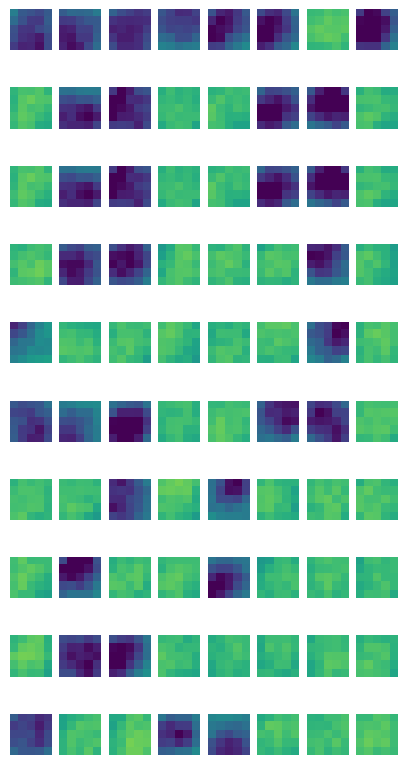

In [87]:
num_images = len(os.listdir(filterpath))
sample_filter = visualise_joint(10)

In [ ]:
sample_filter['0.weight'][7]

tensor([[[-1.5372, -2.2251, -2.1316, -1.3275, -0.8899],
         [-1.6306, -2.2600, -1.6117, -1.4283, -1.0930],
         [-2.2766, -2.0019, -1.7332, -1.5294, -0.7726],
         [-2.5457, -2.1230, -1.7567, -1.1181, -0.8944],
         [-1.8718, -1.3100, -1.1222, -0.6520, -0.3365]]], device='cuda:0')

Visualising IID sampled filters

In [7]:
import matplotlib
def visualise_sampled_IID(num_rows):
    _, axarr = plt.subplots(num_rows, 8, figsize=(int(5*(num_filters//8)), num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        for i in range(8):
            file = np.random.choice(uuids, replace=True)
            filter = torch.load(os.path.join(filterpath, file))
            idx = np.random.choice(8)
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(filter['0.weight'][idx][0].detach().cpu(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

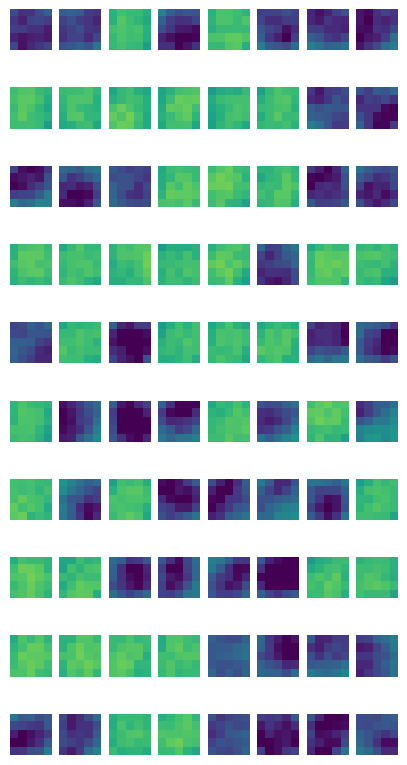

In [10]:
visualise_sampled_IID(10)

553


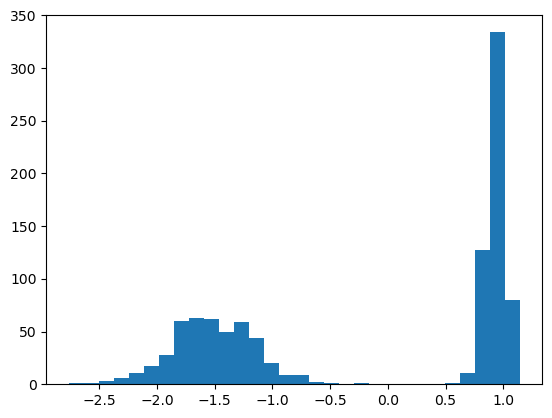

In [17]:
import matplotlib
def histogram_sampled_IID(num_samples):

    vals = []
    uuids = os.listdir(filterpath)
    num_over_0 = 0
    for f in range(num_samples):
        file = np.random.choice(uuids, replace=True)
        filter = torch.load(os.path.join(filterpath, file))
        idx = np.random.choice(8)
        vals.append(np.mean(filter['0.weight'][idx][0].detach().cpu().numpy()))
        if vals[-1] > 0:
            num_over_0 += 1
    plt.hist(vals, bins=30)
    print(num_over_0)


histogram_sampled_IID(1000)

Visualising VAE sampled filters

In [18]:
import torch
import torch.nn as nn

vae_batch_size = 100
x_dim  = 25
hidden_dim1 = 20
hidden_dim2 = 20
hidden_dim3 = 20
hidden_dim4 = 20
latent_dim = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim1)
        self.FC_input2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_input3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_input4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_mean  = nn.Linear(hidden_dim2, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim2, latent_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        self.training = True
        
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        h_       = self.tanh(self.FC_input3(h_))
        h_       = self.tanh(self.FC_input4(h_))

        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim1)
        self.FC_hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_hidden4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_output = nn.Linear(hidden_dim4, output_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        h     = self.tanh(self.FC_hidden(x))
        h     = self.tanh(self.FC_hidden2(h))
        h     = self.tanh(self.FC_hidden3(h))
        h     = self.tanh(self.FC_hidden4(h))

        x_hat = self.FC_output(h)
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        # self.lamb = nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [20]:
model.load_state_dict(torch.load('../data/vae_8.pt'))
model.eval()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=25, out_features=20, bias=True)
    (FC_input2): Linear(in_features=20, out_features=20, bias=True)
    (FC_input3): Linear(in_features=20, out_features=20, bias=True)
    (FC_input4): Linear(in_features=20, out_features=20, bias=True)
    (FC_mean): Linear(in_features=20, out_features=10, bias=True)
    (FC_var): Linear(in_features=20, out_features=10, bias=True)
    (tanh): Tanh()
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=10, out_features=20, bias=True)
    (FC_hidden2): Linear(in_features=20, out_features=20, bias=True)
    (FC_hidden3): Linear(in_features=20, out_features=20, bias=True)
    (FC_hidden4): Linear(in_features=20, out_features=20, bias=True)
    (FC_output): Linear(in_features=20, out_features=25, bias=True)
    (tanh): Tanh()
  )
)

In [21]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)
    # net[0].weight[c,:,:,:] = generated_filter[0].view(5, 5)


In [22]:
def show_image(x, idx):
    x = x.view(vae_batch_size, 5, 5)
    fig = plt.figure()
    print(x[idx])
    plt.imshow(x[idx].cpu().numpy())

In [23]:
torch.max(generated_images[1])

tensor(1.1505, device='cuda:0')

tensor([[-1.0143, -1.4931, -1.6037, -1.5741, -1.2096],
        [-1.4327, -1.8914, -1.9284, -1.8595, -1.5069],
        [-1.5927, -1.9458, -1.9688, -1.8979, -1.5202],
        [-1.5272, -1.8361, -1.9093, -1.7555, -1.2557],
        [-1.1491, -1.4524, -1.4916, -1.2564, -0.7788]], device='cuda:0')


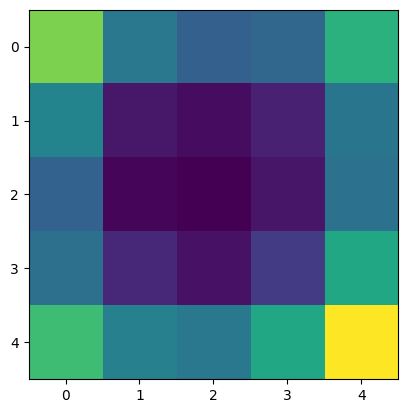

In [24]:
show_image(generated_images, idx=12)

In [25]:
def visualise_vae(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 5, 5)

  for i in range(num_rows):
    for j in range(num_filters):
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[num_filters*i+j].cpu().numpy(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

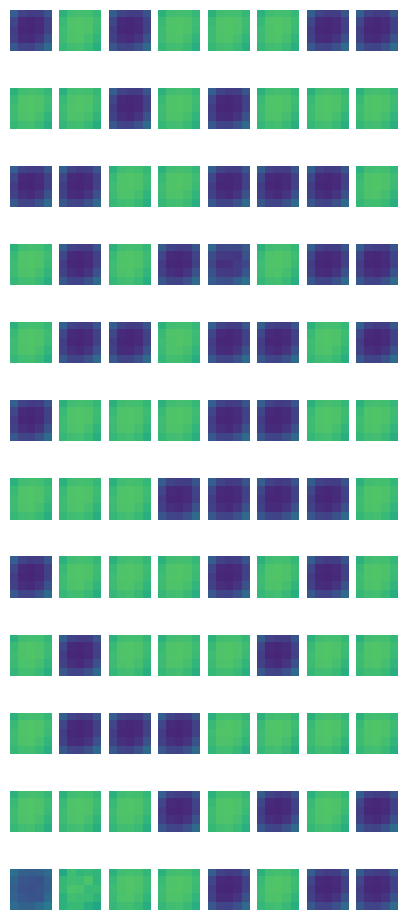

In [26]:
visualise_vae(100//num_filters, generated_images)

In [31]:
def visualise_random(num_rows):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  for i in range(num_rows):
    for j in range(num_filters):
      axarr[i, j].set_axis_off()
      val = (vmin - vmax) * torch.rand(5, 5) + vmax
      axarr[i, j].imshow(val.cpu().numpy(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

IndexError: index 8 is out of bounds for axis 1 with size 8

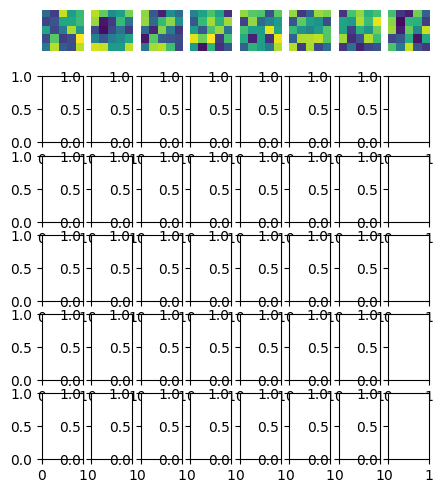

In [32]:
visualise_random(6)

# Looking at Results

In [ ]:
import pickle
import numpy as np

In [ ]:
files = ['joint', 'random', 'sampled_iid', 'vae']

In [ ]:
res = {}
for file in files:
    with open('../data/save_baselines_' + file + '_file.pickle', 'rb') as f:
        res[file] = pickle.load(f)

In [ ]:
d = res['joint']['joint_IID']['acc']
print('joint', np.mean(d), np.std(d))

joint 0.45455199999999996 0.12400282938707488


In [ ]:
d = res['sampled_iid']['sample_filters_IID_16']['acc']
print('sampled iid', np.mean(d), np.std(d))

sampled iid 0.477316 0.098790787748656


In [ ]:
d = res['random']['random_16']['acc']
print('random', np.mean(d), np.std(d))

random 0.17172 0.099667619616403


In [ ]:
d = res['vae']['vae_IID_16']['acc']
print('vae', np.mean(d), np.std(d))

vae 0.5837720000000001 0.06628210932069076


Visualize MNIST

In [ ]:
from torchvision import datasets, transforms

In [ ]:
mnist_mean, mnist_std = (0.1307,), (0.3081,)
mnist_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
    ])
mnist_train = datasets.MNIST('../../data', train=True, download=True,
                    transform=mnist_transform)

In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True)

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data[0][0])
    break

In [116]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=8
ngpu=1
netG_load = '../dcgan-out/netG_epoch_990.pth'
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 25),
            
            
            # EDITED


        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(netG_load))



def visualise_dcgan(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[i].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-.3, vmax=.3, clip=False), interpolation=None)

def histogram_dcgan(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples // 8):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            vals.append(np.mean(fake[i].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)


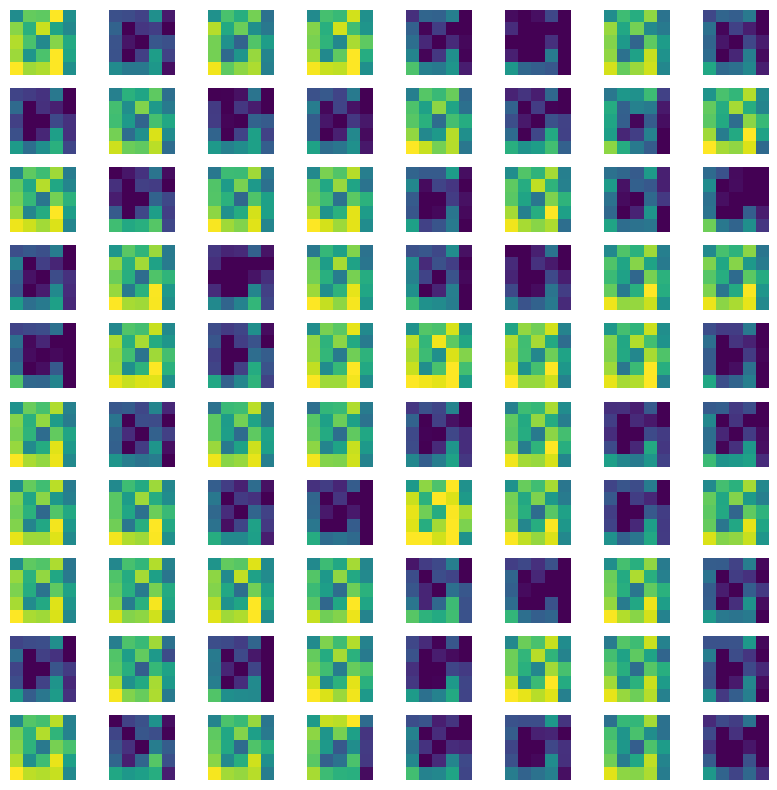

In [117]:

# histogram_dcgan(10000)
visualise_dcgan(netG, 10, nz)

In [4]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=32
nc = 8
ngpu=1
netG_load = '../dcgan-out/netG_epoch_990.pth'
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 25 * 8),
            
            
            # EDITED


        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(netG_load))



def visualise_dcgan_joint(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        noise = torch.randn(2, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[0,i*25:i*25 + 25].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-.3, vmax=.3, clip=False), interpolation=None)

def histogram_dcgan_joint(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples):
        noise = torch.randn(2, nz, device=device)
        fake = netG(noise)
        for i in range(8):
            vals.append(np.mean(fake[0,i*25:i*25 + 25].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)


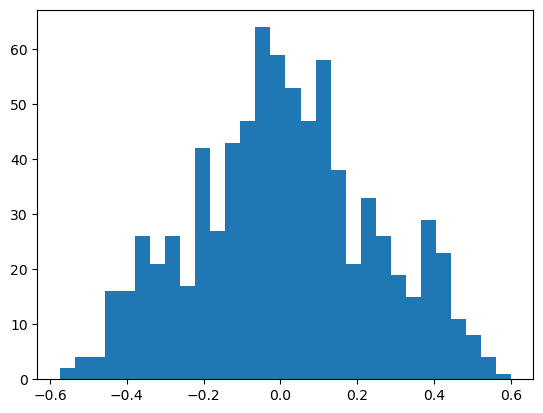

In [5]:
histogram_dcgan_joint(100)